# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 128
- Learning rate = 0.001
- Hidden unit = 200
- Epochs = 100
- N = 50
- Data Length = 100K
- Data = [single_Ctype4_error_rate_1]
- Deduplication
- Random split

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json
import numpy as np

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
best_f1_score = []
rnn = "lstm"
data_name = "copy"
dir_name = "separator_Ctype4_30"
pretrained_dir_name = None
iterator = list(range(1,11,1))
epochs = 100

train_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_train.txt"
dev_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_test.txt"
config_path = "models/config.json"

# Prepare dataset

In [ ]:
for i in iterator:
        print("rnn : %s" % rnn)
        max_len = 65
        src = fields.SourceField()
        srcp = fields.SourceField()
        tgt = fields.TargetField()
        tgtp = fields.TargetField()
        def len_filter(example):
            return len(example.src) <= max_len and len(example.tgt) <= max_len
        train = torchtext.data.TabularDataset(
            path=train_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        dev = torchtext.data.TabularDataset(
            path=dev_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        src.build_vocab(train)
        tgt.build_vocab(train)
        input_vocab = src.vocab
        output_vocab = tgt.vocab

        print("src vocab size = %d" % (len(src.vocab)))
        print("tat vacab size = %d" % (len(tgt.vocab)))

        weight = torch.ones(len(tgt.vocab))
        pad = tgt.vocab.stoi[tgt.pad_token]
        loss = Perplexity(weight, pad)
        if torch.cuda.is_available():
            loss.cuda()
        '''
        {
            "max_len": 104,
            "embedding_size": 5,
            "hidden_size": 200,
            "input_dropout_p": 0,
            "dropout_p": 0,
            "n_layers": 1,
            "bidirectional": false,
            "rnn_cell": "lstm",
            "variable_lengths": false,
            "embedding": null,
            "update_embedding": true,
            "get_context_vector": false,
            "use_attention": true,
            "attn_layers": 1,
            "hard_attn": false,
            "position_embedding": false,
            "pos_add": "add"
        }

        '''

        optimizer = "Adam"
        seq2seq = None
        config_json = open(config_path).read()
        config = json.loads(config_json)
        config["max_len"] = max_len
        config["hidden_size"] = 100
        config["rnn_cell"] = rnn
        config["embedding_size"] = 20
        config["use_attention"] = False
        config["position_embedding"] = "sin"
        config["use_memory"] = "stack"
        #config["pos_add"] = "cat"

        print("Train_path : %s" % train_path)
        print("Dev_path = %s" % dev_path)
        print(json.dumps(config, indent=4))

        save_path = (data_name + "_rand_" + dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + ("_pretrained" if pretrained_dir_name is not None else ""))
        print("Save_path : %s" % save_path)
        
        if pretrained_dir_name is not None:
            pretrained_path = ("pretrained_weights/"+ data_name + "_rand_" + pretrained_dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + "_"+rnn+"_"+str(i))
            pretrained_pos_weight = np.load(pretrained_path+"/decoder_pos_weight.npy")
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id,
                              pretrained_pos_weight)
        else :
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
        
        if torch.cuda.is_available():
            seq2seq.cuda()

        for param in seq2seq.parameters():
            param.data.uniform_(-0.08, 0.08)

        # train
        t = Trainer(loss=loss, batch_size=128,
                    learning_rate=0.002,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=config["hidden_size"],
                    path=save_path,
                    file_name=config["rnn_cell"] + "_" + str(i))

        seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                 num_epochs=epochs, dev_data=dev,
                                                                                 optimizer=optimizer,
                                                                                 teacher_forcing_ratio=0.5)

        character_accuracy.append(character_accuracy_list)
        sentence_accuracy.append(sentence_accuracy_list)
        f1_score.append(f1_score_list)
        best_f1_score.append(max(f1_score_list))

rnn : lstm
src vocab size = 7
tat vacab size = 10


/root/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2020-03-09 05:50:24,551 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Train_path : data/copy_rand/correction_separator_Ctype4_30/data_train.txt
Dev_path = data/copy_rand/correction_separator_Ctype4_30/data_test.txt
{
    "max_len": 65,
    "embedding_size": 20,
    "hidden_size": 100,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "position_embedding": "sin",
    "pos_add": "add",
    "memory_dim": 5
}
Save_path : copy_rand_separator_Ctype4_30_att_with_pos_sin_emb20_hidden100


/root/venv/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-03-09 05:51:40,515 INFO   Finished epoch 1: Train loss: 2.4656, Dev loss: 2.0272, Accuracy(character): 0.7871, Accuracy(sentence): 0.0000, F1 Score: 0.0000
2020-03-09 05:52:54,667 INFO   Finished epoch 2: Train loss: 1.9364, Dev loss: 1.8553, Accuracy(character): 0.8166, Accuracy(sentence): 0.0760, F1 Score: 0.2793
2020-03-09 05:54:08,854 INFO   Finished epoch 3: Train loss: 1.9224, Dev loss: 1.9841, Accuracy(character): 0.7926, Accuracy(sentence): 0.0505, F1 Score: 0.1825


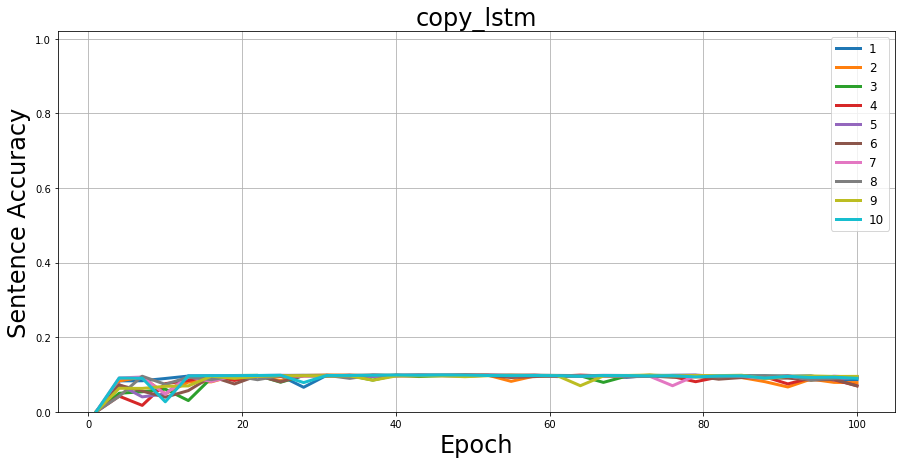

In [11]:
plt.figure(figsize=(15,7))
for j in range(len(sentence_accuracy)):
    plt.plot(list(range(1, len(sentence_accuracy[j])+1, 1))[::3], sentence_accuracy[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

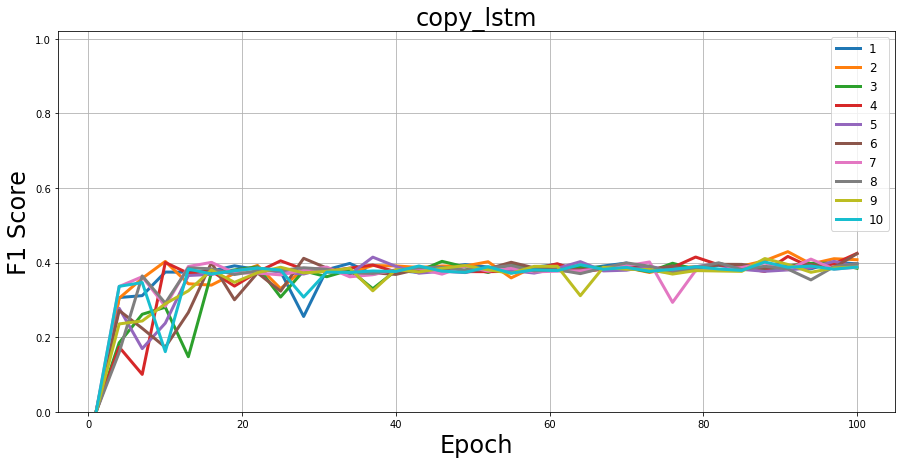

In [12]:
plt.figure(figsize=(15,7))
for j in range(len(f1_score)):
    plt.plot(list(range(1, len(f1_score[j])+1, 1))[::3], f1_score[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

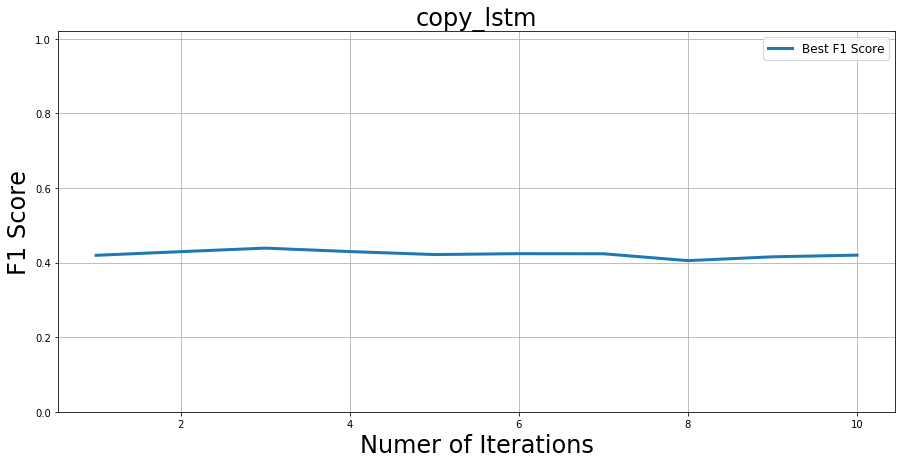

In [13]:
plt.figure(figsize=(15,7))
plt.plot(list(range(1, len(best_f1_score)+1)), best_f1_score, '-', LineWidth=3, label="Best F1 Score")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Numer of Iterations', fontsize=24)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

In [14]:
print(f1_score)

[[0, 0.279343071105509, 0.1825325755222135, 0.30627731353654297, 0.35901849478117565, 0.36466309691332083, 0.31138643714708625, 0.3588121978700977, 0.10786789980439447, 0.37457190269392365, 0.3643146691645537, 0.41945512820512826, 0.37414734580610515, 0.3443489420625137, 0.3858036107441656, 0.37729459989306724, 0.3665422772367343, 0.24494165895439782, 0.3912679008033531, 0.39015191199580934, 0.3723096923299148, 0.38128996633476425, 0.38220183812418895, 0.3725344855639723, 0.37599344238925125, 0.37069652823077476, 0.37957221735789715, 0.2554964636219091, 0.386721435749167, 0.3755870234089641, 0.38083007829917775, 0.37011952191235065, 0.3708038189097629, 0.3978375764275104, 0.37635046468568556, 0.3682706137236696, 0.36899241721673665, 0.38345317354638264, 0.13975149759141084, 0.3791913303170658, 0.36893203883495146, 0.38868462255686714, 0.37355699855699853, 0.3855494194279241, 0.37285561922666716, 0.385184922771716, 0.3827524893314367, 0.3873258093572829, 0.3946153980112498, 0.3888712913

In [15]:
print(best_f1_score)

[0.41945512820512826, 0.4292681382018558, 0.43876112366023373, 0.4295272429590214, 0.42152933893721695, 0.4238648194121887, 0.42361434186251706, 0.40519392344903676, 0.4154545747734383, 0.4199384897264756]


In [16]:
print(sum(best_f1_score, 0.0)/len(best_f1_score))

0.42266071211871126
